In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

from convolutional_ar.model import ConvAR

# Autoregressive Models

## AR: Time Series

In [2]:
def simulate_ar(n: int, w: np.ndarray) -> np.ndarray:
    """Simulate AR(p) process.

    :param n : number of samples
    :param w : weight vector
    :returns x: signal
    """

    # order (how many past values)
    p = len(w)

    # pad for initilization
    x = np.random.randn(n + p)

    # randomness
    error = np.random.randn(len(x))

    # create signal
    for i in range(p, len(x)):
        # use past values to generate future values
        x[i] = (x[i-p:i] @ w) + error[i-p]

    # remove initial padding
    x = x[p:]

    # normalize
    x = (x - x.mean()) / x.std()

    return x

## AR(1)

AR(1) refers to using a single past value to predict future values.

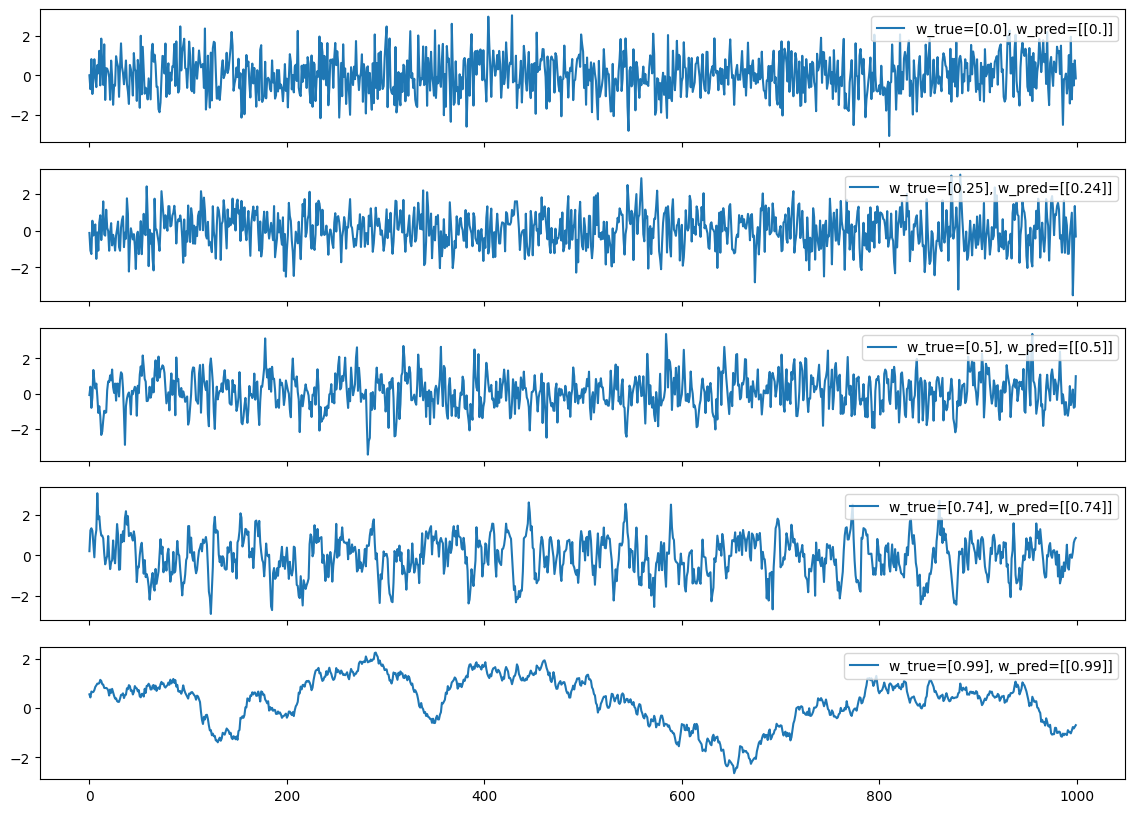

In [3]:
# Simulate a few examples and plot
weights = np.linspace(0, 0.99, 5).reshape(-1, 1)

fig, axes = plt.subplots(nrows=len(weights), ncols=1, figsize=(14, 10), sharex=True)

for i in range(len(weights)):

    # Simulate
    x = simulate_ar(10_000, weights[i])

    # Fit AR(1) coefficient
    past_values = x[:-1]
    future_values = x[1:]
    w_pred, residuals, rank, singular_values = np.linalg.lstsq(past_values.reshape(-1, 1), future_values)

    axes[i].plot(x[:1000], label=f"w_true=[{weights[i, 0].round(2)}], w_pred=[{w_pred.round(2)}]")
    axes[i].legend(loc="upper right")

### AR(3)

AR(3) uses the past three values to predict future values. As the complexity of the model increases, the model can flexibly model various forms.

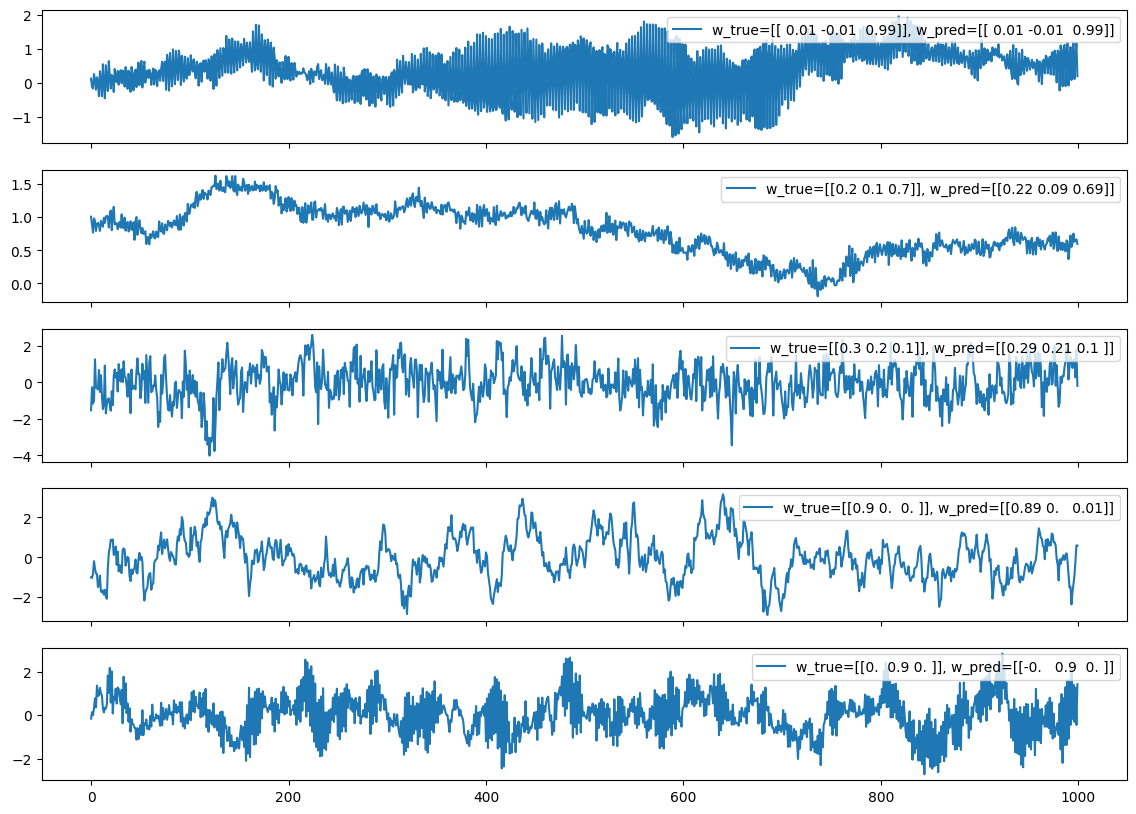

In [4]:
# Simulate a few examples and plot
np.random.seed(0)
weights = np.array([
    [0.99, -.01, .01],
    [0.7, .1, .2],
    [.1, .2, .3],
    [0, 0, .9],
    [0, 0.9, 0]
])

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 10), sharex=True)

for i in range(len(weights)):

    # Simulate
    x = simulate_ar(10_000, weights[i])

    # Use statsmodels to fit AR(1) coefficient
    past_values = np.lib.stride_tricks.sliding_window_view(x, 3, axis=0)[:-1]
    future_values = x[3:]
    w_pred, residuals, rank, singular_values = np.linalg.lstsq(past_values.reshape(-1, 3), future_values)

    axes[i].plot(x[:1000], label=f"w_true=[{weights[i][::-1].round(2)}], w_pred=[{w_pred[::-1].round(2)}]")
    axes[i].legend(loc="upper right")

### AR(3): Solve with Pytorch

In [5]:
# Define model
class Model(torch.nn.Module):
    def __init__(self, n_past_values):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(n_past_values))
        self.b = torch.nn.Parameter(torch.randn(1))
    def forward(self, past_values):
        return past_values.matmul(self.w) + self.b

# Simulate
w_true = np.array([0.7, .1, .2])
x = simulate_ar(10_000, w_true)
x = (x - x.mean()) / x.std()

# Past and future values
past_values = torch.from_numpy(
    np.lib.stride_tricks.sliding_window_view(x, 3, axis=0)[:-1].copy()
).float()
future_values = torch.from_numpy(x[3:]).float()

# Setup model
model = Model(3)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.)

# Training
for i in range(2000):
    predicted_future_values = model(past_values)
    loss = loss_fn(future_values, predicted_future_values)
    loss.backward()       # compute gradient
    optimizer.step()      # step parameters in direction of gradient
    optimizer.zero_grad() # reset gradient

print("predicted weights: ", model.w.detach().numpy())
print("true weights: ", w_true)

predicted weights:  [0.690424   0.1005022  0.20871922]
true weights:  [0.7 0.1 0.2]


## AR: Images

## AR(2): 2d

#### Contrained by Distance

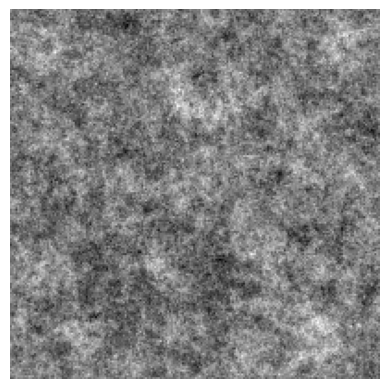

In [6]:
# Settings
n, sweeps = 200, 200
w = np.array([0.9, 0.1], dtype=np.float32)
w0, w1 = map(float, w)

# Symmetric kernel
kernel = torch.tensor([
    [w1, w0, w1],
    [w0, 0., w0],
    [w1, w0, w1],
], dtype=torch.float32)

k = kernel[None, None]  # unsqueeze to (1, 1, 3,3)

# Simulate
img = torch.zeros(n + 2, n + 2, dtype=torch.float32)
for _ in range(sweeps):
    for a in (0, 1):
        for b in (0, 1):
            eps = torch.randn_like(img)
            
            # weighted neighbor sum
            mu = F.conv2d(img[None, None], k)[0, 0]

            # update only this sublattice of interior pixels
            img[1+a:n+1:2, 1+b:n+1:2] = mu[a::2, b::2] / 4.0 + eps[1+a:n+1:2, 1+b:n+1:2]

patches = F.unfold(img[None, None], kernel_size=3).squeeze(0).T
axis_idx, diag_idx, center_idx = [1,3,5,7], [0,2,6,8], 4

# Xw = y
X = torch.stack([patches[:, axis_idx].mean(1),
                 patches[:, diag_idx].mean(1)], dim=1)
y = patches[:, center_idx]

# Plot
img_show = img[1:n+1, 1:n+1]
img_show = (img_show - img_show.mean()) / img_show.std().clamp_min(1e-8)
plt.imshow(img_show.numpy(), cmap="gray"); plt.axis("off"); plt.show()


In [7]:
# Solve with least squares
w_pred, *_ = np.linalg.lstsq(X.numpy(), y.numpy(), rcond=None)
print("w_pred:", w_pred)
print("w_true:", w)

w_pred: [0.89416593 0.1058778 ]
w_true: [0.9 0.1]


In [8]:
# Solve with pytorch, our package
model = ConvAR(radius=1, lr=1e-1, n_epochs=100)
model.fit(img)
print()
print("w_pred:", model.weight_vector_ * 4)
print("w_true:", w)

model 0, epoch 99, loss 0.9986103773117065

w_pred: tensor([[0.8926, 0.1108]])
w_true: [0.9 0.1]


## Unconstrained

Above assumes a distance contrained kernel. Below shows how to simulate and solve without that constraint.

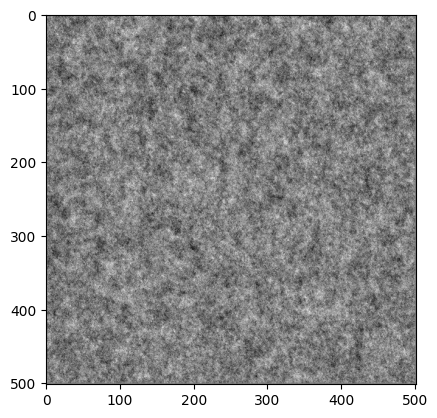

In [9]:
# Settings
n, sweeps = 500, 1000
torch.manual_seed(0)
kernel = torch.empty((3, 3)).uniform_(0.1, 0.8)
kernel = kernel / kernel.norm()
kernel = kernel * 0.39
kernel[1, 1] = 0.0
k = kernel[None, None]

img = torch.zeros(n + 2, n + 2, dtype=torch.float32)
for _ in range(sweeps):
    for a in (0, 1):
        for b in (0, 1):
            mu = F.conv2d(img[None, None], k)[0, 0]
            sl = (slice(1+a, n+1, 2), slice(1+b, n+1, 2))
            img[sl] = mu[a::2, b::2] + torch.randn_like(img[sl])

plt.imshow(img, cmap="gray");

### Least Squares

In [10]:
# unfold patches over interior pixels
patches = F.unfold(img[None, None], kernel_size=3).squeeze(0).T  # (n*n, 9)
nbr_idx = torch.where((k[0, 0] != 0).flatten())[0].tolist()
X = patches[:, nbr_idx]
y = patches[:, 4]

# solve for the 8 weights
w8, *_ = np.linalg.lstsq(X.numpy(), y.numpy(), rcond=None)

# reconstruct 3x3 kernel estimate
k_hat = np.zeros((3,3), dtype=np.float32)
k_hat.flat[nbr_idx] = w8
k_hat[1, 1] = 0.0
print("true kernel:\n", kernel.numpy())
print()
print("fit kernel:\n", k_hat)

true kernel:
 [[0.12442591 0.17737347 0.04503739]
 [0.05351652 0.         0.1512578 ]
 [0.12322602 0.20233655 0.11651613]]

fit kernel:
 [[0.11979789 0.18837987 0.08065967]
 [0.10793715 0.         0.10793834]
 [0.0807171  0.18847145 0.11987015]]


### Torch

In [ ]:
class ConvAR(nn.Module):
    def __init__(self, kernel):
        super().__init__()
        self.kernel = nn.Parameter(kernel.clone().float())

        # mask out center weight
        mask = torch.ones_like(self.kernel)
        mask[:, :, mask.shape[2] // 2, mask.shape[3] // 2] = 0.0
        self.register_buffer("mask", mask)

    def forward(self, X):
        k = self.kernel * self.mask
        pad = (k.shape[-1] // 2)
        Xp = F.pad(X, (pad, pad, pad, pad))
        return F.conv2d(Xp, k, padding=0)

def train(im, model, n_epochs=2000, lr=1e-2, loss_fn=nn.MSELoss(), verbose=False):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
    for i in range(n_epochs):
        opt.zero_grad(set_to_none=True)
        im_pred = model(im)
        loss = loss_fn(im_pred, im)
        loss.backward()
        opt.step()
    return model

model = ConvAR(torch.zeros((1, 1, 3, 3)))
model = train(img[None, None].float(), model, n_epochs=2000, lr=1e-2, verbose=True)

In [16]:
print("true kernel:\n", kernel.numpy())
print()
print("fit kernel:\n", model.kernel.detach().cpu().numpy())

true kernel:
 [[0.12442591 0.17737347 0.04503739]
 [0.05351652 0.         0.1512578 ]
 [0.12322602 0.20233655 0.11651613]]

fit kernel:
 [[[[0.11947048 0.18840483 0.08046981]
   [0.10814351 0.         0.10814349]
   [0.0804698  0.18840484 0.11947049]]]]
